# Machine Learning Classification Models and Evaluation Metrics

## Dataset: 10 Monkey Species Image Classification

This notebook implements 6 classification models and calculates 6 evaluation metrics for each model.

### Models:
1. Logistic Regression
2. Decision Tree Classifier
3. K-Nearest Neighbor Classifier
4. Naive Bayes Classifier (Gaussian)
5. Ensemble Model - Random Forest
6. Ensemble Model - XGBoost

### Evaluation Metrics:
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC Score)

## 1. Import Required Libraries

In [2]:
# Data Processing
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Image Processing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## 2. Load and Explore the Dataset

In [3]:
# Dataset paths
dataset_path = '/Users/vjadon/Downloads/archive (1)/'
train_path = os.path.join(dataset_path, 'training/training/')
val_path = os.path.join(dataset_path, 'validation/validation/')

# Class labels
class_names = {
    'n0': 'mantled_howler',
    'n1': 'patas_monkey',
    'n2': 'bald_uakari',
    'n3': 'japanese_macaque',
    'n4': 'pygmy_marmoset',
    'n5': 'white_headed_capuchin',
    'n6': 'silvery_marmoset',
    'n7': 'common_squirrel_monkey',
    'n8': 'black_headed_night_monkey',
    'n9': 'nilgiri_langur'
}

classes = list(class_names.keys())
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

Number of classes: 10
Classes: ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


## 3. Image Loading and Feature Extraction

In [4]:
def load_images_and_labels(data_path, img_size=(64, 64)):
    """
    Load images from directory structure and extract features
    
    Args:
        data_path: Path to the data directory
        img_size: Tuple of (width, height) for resizing images
    
    Returns:
        X: Feature array (flattened images)
        y: Label array
    """
    X = []
    y = []
    
    print(f"Loading images from {data_path}...")
    
    for class_label in tqdm(classes):
        class_path = os.path.join(data_path, class_label)
        
        if not os.path.exists(class_path):
            print(f"Warning: {class_path} does not exist!")
            continue
        
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_path, img_name)
                
                try:
                    # Load and preprocess image
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(img_size)
                    
                    # Convert to array and normalize
                    img_array = np.array(img) / 255.0
                    
                    # Flatten the image
                    img_flat = img_array.flatten()
                    
                    X.append(img_flat)
                    y.append(class_label)
                    
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(X), np.array(y)

# Load training data
X_train, y_train = load_images_and_labels(train_path)

# Load validation data
X_val, y_val = load_images_and_labels(val_path)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Loading images from /Users/vjadon/Downloads/archive (1)/training/training/...


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.25it/s]


Loading images from /Users/vjadon/Downloads/archive (1)/validation/validation/...


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.60it/s]


Training set shape: (1097, 12288)
Training labels shape: (1097,)
Validation set shape: (272, 12288)
Validation labels shape: (272,)


## 4. Data Distribution Analysis

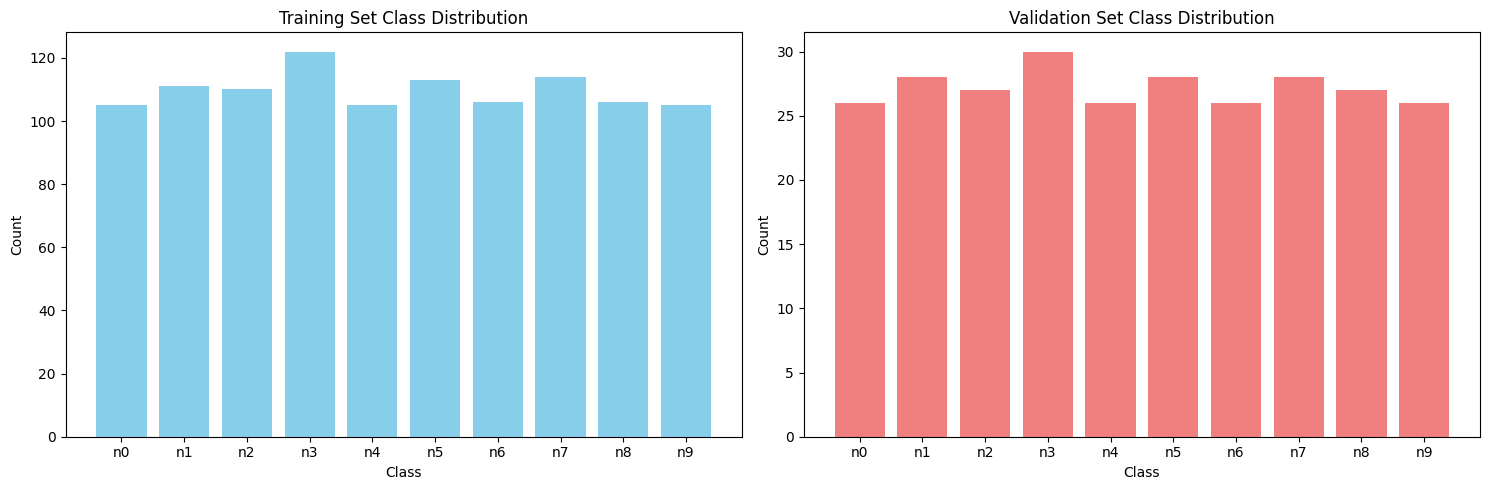


Training set class counts:
n0    105
n1    111
n2    110
n3    122
n4    105
n5    113
n6    106
n7    114
n8    106
n9    105
Name: count, dtype: int64

Validation set class counts:
n0    26
n1    28
n2    27
n3    30
n4    26
n5    28
n6    26
n7    28
n8    27
n9    26
Name: count, dtype: int64


In [5]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Training set distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[0].bar(range(len(train_counts)), train_counts.values, color='skyblue')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xticks(range(len(classes)))
axes[0].set_xticklabels(classes)

# Validation set distribution
val_counts = pd.Series(y_val).value_counts().sort_index()
axes[1].bar(range(len(val_counts)), val_counts.values, color='lightcoral')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')
axes[1].set_title('Validation Set Class Distribution')
axes[1].set_xticks(range(len(classes)))
axes[1].set_xticklabels(classes)

plt.tight_layout()
plt.show()

print("\nTraining set class counts:")
print(train_counts)
print("\nValidation set class counts:")
print(val_counts)

## 5. Feature Scaling

In [6]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Feature scaling completed!")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Validation data shape: {X_val_scaled.shape}")

Feature scaling completed!
Training data shape: (1097, 12288)
Validation data shape: (272, 12288)


## 6. Define Evaluation Function

In [7]:
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n{'='*60}")
    print(f"Evaluating: {model_name}")
    print(f"{'='*60}")
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # For AUC score, we need probability predictions
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
    else:
        y_pred_proba = None
    
    # Calculate metrics
    metrics = {}
    
    # 1. Accuracy
    metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    
    # 2. AUC Score (one-vs-rest for multiclass)
    if y_pred_proba is not None:
        # Binarize labels for multiclass AUC
        y_test_bin = label_binarize(y_test, classes=classes)
        metrics['AUC Score'] = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr', average='weighted')
    else:
        metrics['AUC Score'] = 'N/A'
    
    # 3. Precision (weighted average for multiclass)
    metrics['Precision'] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # 4. Recall (weighted average for multiclass)
    metrics['Recall'] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # 5. F1 Score (weighted average for multiclass)
    metrics['F1 Score'] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    # 6. Matthews Correlation Coefficient
    metrics['MCC Score'] = matthews_corrcoef(y_test, y_pred)
    
    # Print metrics
    print("\nEvaluation Metrics:")
    print("-" * 40)
    for metric_name, value in metrics.items():
        if isinstance(value, str):
            print(f"{metric_name:<25}: {value}")
        else:
            print(f"{metric_name:<25}: {value:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return metrics, y_pred

print("Evaluation function defined!")

Evaluation function defined!


## 7. Model Training and Evaluation

### 7.1 Logistic Regression

Training Logistic Regression...
Training completed!

Evaluating: Logistic Regression

Evaluation Metrics:
----------------------------------------
Accuracy                 : 0.5735
AUC Score                : 0.8893
Precision                : 0.5717
Recall                   : 0.5735
F1 Score                 : 0.5660
MCC Score                : 0.5275


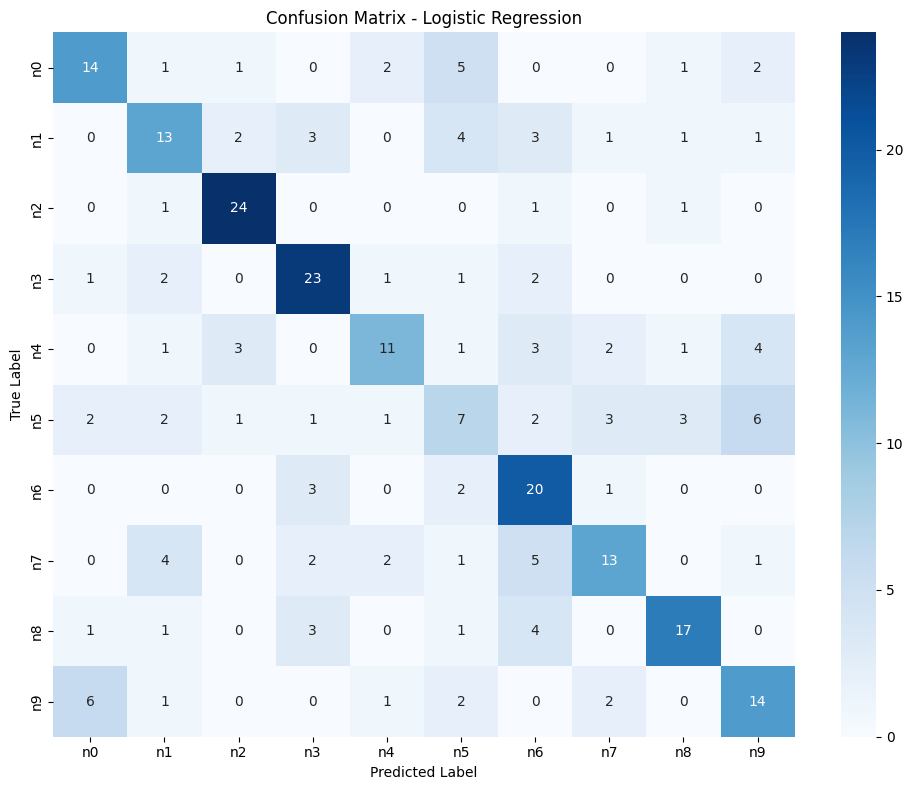

In [8]:
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
print("Training completed!")

lr_metrics, lr_pred = evaluate_model(lr_model, X_val_scaled, y_val, "Logistic Regression")

### 7.2 Decision Tree Classifier

Training Decision Tree Classifier...
Training completed!

Evaluating: Decision Tree Classifier

Evaluation Metrics:
----------------------------------------
Accuracy                 : 0.4154
AUC Score                : 0.6749
Precision                : 0.4179
Recall                   : 0.4154
F1 Score                 : 0.4144
MCC Score                : 0.3506


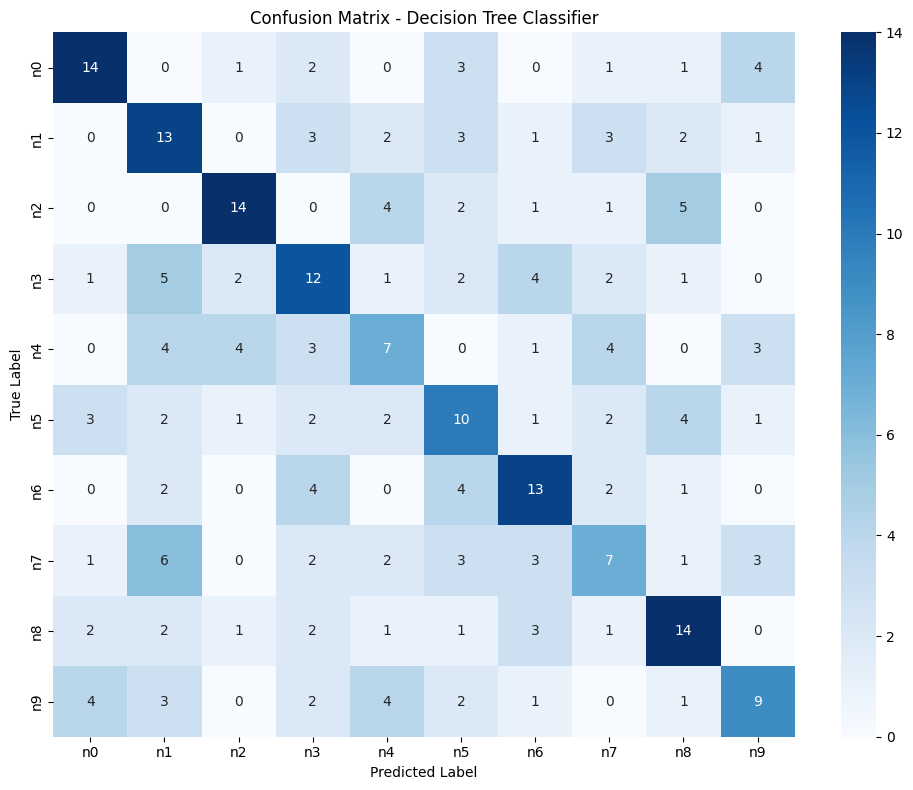

In [9]:
print("Training Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(random_state=42, max_depth=20)
dt_model.fit(X_train_scaled, y_train)
print("Training completed!")

dt_metrics, dt_pred = evaluate_model(dt_model, X_val_scaled, y_val, "Decision Tree Classifier")

### 7.3 K-Nearest Neighbor Classifier

Training K-Nearest Neighbor Classifier...
Training completed!

Evaluating: K-Nearest Neighbor Classifier

Evaluation Metrics:
----------------------------------------
Accuracy                 : 0.3272
AUC Score                : 0.7164
Precision                : 0.4600
Recall                   : 0.3272
F1 Score                 : 0.2765
MCC Score                : 0.2658


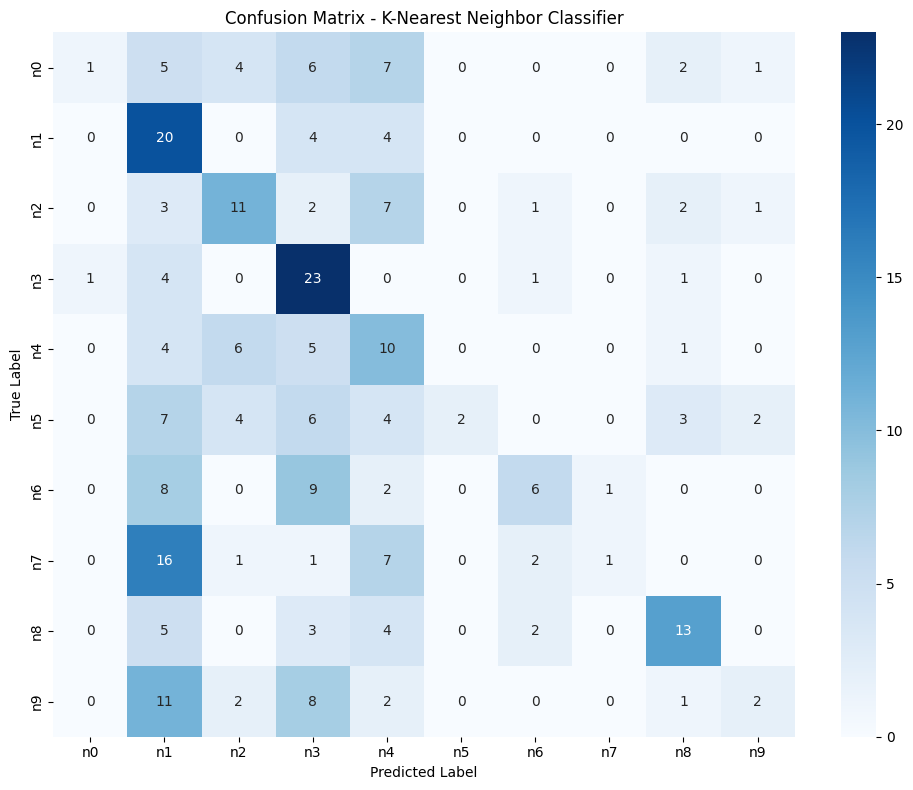

In [10]:
print("Training K-Nearest Neighbor Classifier...")
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_scaled, y_train)
print("Training completed!")

knn_metrics, knn_pred = evaluate_model(knn_model, X_val_scaled, y_val, "K-Nearest Neighbor Classifier")

### 7.4 Naive Bayes Classifier (Gaussian)

Training Gaussian Naive Bayes Classifier...
Training completed!

Evaluating: Gaussian Naive Bayes Classifier

Evaluation Metrics:
----------------------------------------
Accuracy                 : 0.4154
AUC Score                : 0.7505
Precision                : 0.4271
Recall                   : 0.4154
F1 Score                 : 0.3902
MCC Score                : 0.3579


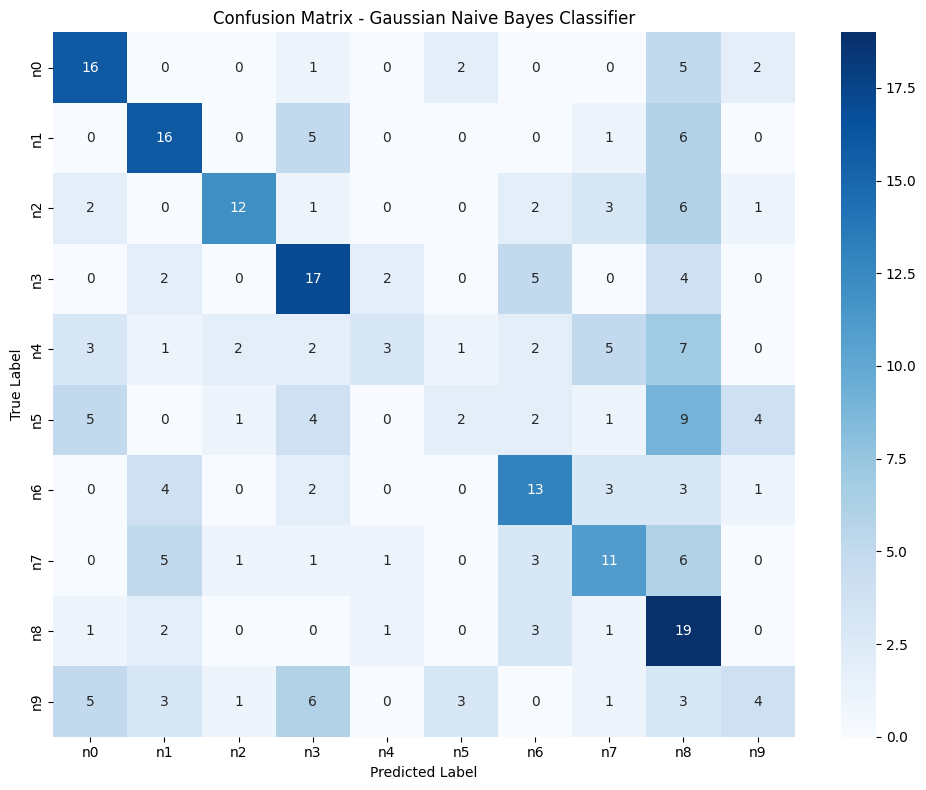

In [11]:
print("Training Gaussian Naive Bayes Classifier...")
nb_model = GaussianNB()
nb_model.fit(X_train_scaled, y_train)
print("Training completed!")

nb_metrics, nb_pred = evaluate_model(nb_model, X_val_scaled, y_val, "Gaussian Naive Bayes Classifier")

### 7.5 Random Forest Classifier

Training Random Forest Classifier...
Training completed!

Evaluating: Random Forest Classifier

Evaluation Metrics:
----------------------------------------
Accuracy                 : 0.5735
AUC Score                : 0.8810
Precision                : 0.5813
Recall                   : 0.5735
F1 Score                 : 0.5656
MCC Score                : 0.5280


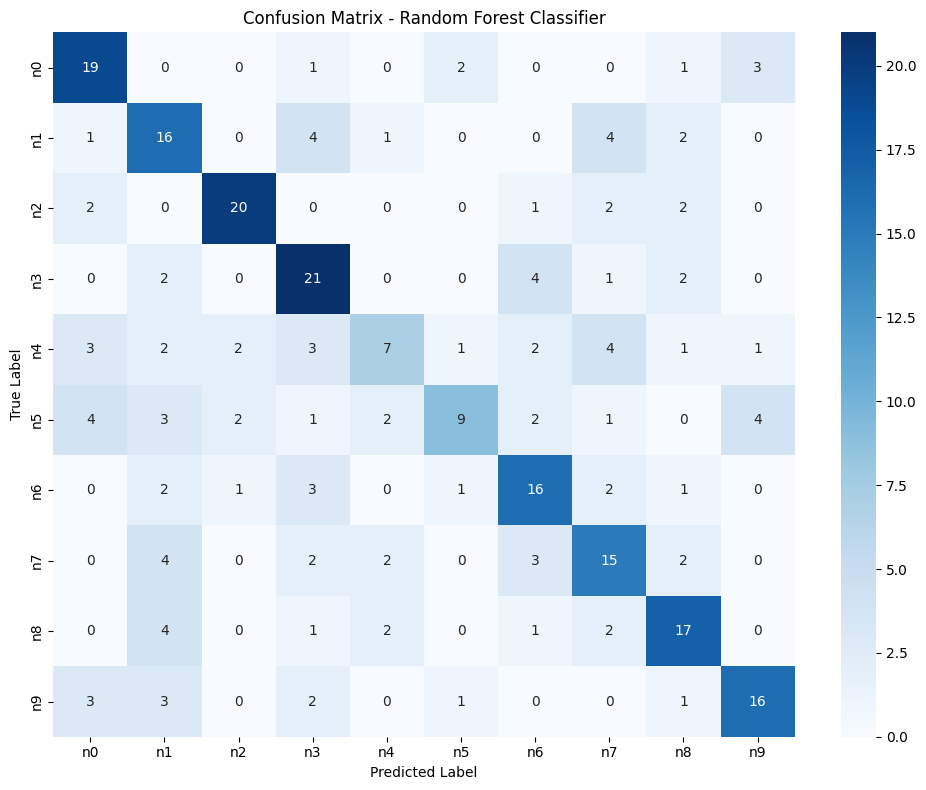

In [12]:
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20)
rf_model.fit(X_train_scaled, y_train)
print("Training completed!")

rf_metrics, rf_pred = evaluate_model(rf_model, X_val_scaled, y_val, "Random Forest Classifier")

### 7.6 XGBoost Classifier

Training XGBoost Classifier...
Training completed!

Evaluating: XGBoost Classifier

Evaluation Metrics:
----------------------------------------
Accuracy                 : 0.5735
AUC Score                : 0.8930
Precision                : 0.5767
Recall                   : 0.5735
F1 Score                 : 0.5646
MCC Score                : 0.5278


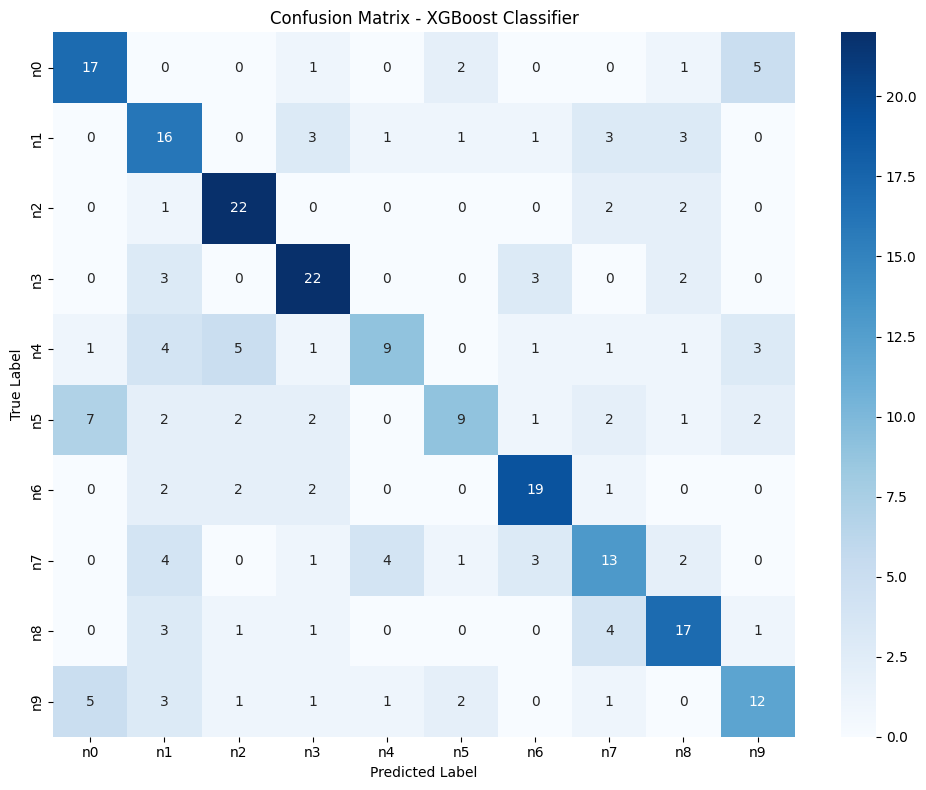

In [13]:
print("Training XGBoost Classifier...")

# Encode labels to numeric for XGBoost
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    learning_rate=0.1,
    n_jobs=-1,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_scaled, y_train_encoded)
print("Training completed!")

# For evaluation, we need to temporarily use encoded labels
print(f"\n{'='*60}")
print(f"Evaluating: XGBoost Classifier")
print(f"{'='*60}")

y_pred_encoded = xgb_model.predict(X_val_scaled)
y_pred_proba = xgb_model.predict_proba(X_val_scaled)

# Calculate metrics
xgb_metrics = {}
xgb_metrics['Accuracy'] = accuracy_score(y_val_encoded, y_pred_encoded)

# AUC Score
y_val_bin = label_binarize(y_val_encoded, classes=range(len(classes)))
xgb_metrics['AUC Score'] = roc_auc_score(y_val_bin, y_pred_proba, multi_class='ovr', average='weighted')

xgb_metrics['Precision'] = precision_score(y_val_encoded, y_pred_encoded, average='weighted', zero_division=0)
xgb_metrics['Recall'] = recall_score(y_val_encoded, y_pred_encoded, average='weighted', zero_division=0)
xgb_metrics['F1 Score'] = f1_score(y_val_encoded, y_pred_encoded, average='weighted', zero_division=0)
xgb_metrics['MCC Score'] = matthews_corrcoef(y_val_encoded, y_pred_encoded)

# Print metrics
print("\nEvaluation Metrics:")
print("-" * 40)
for metric_name, value in xgb_metrics.items():
    print(f"{metric_name:<25}: {value:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val_encoded, y_pred_encoded)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - XGBoost Classifier')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 8. Comparative Analysis of All Models

In [14]:
# Compile all results
all_results = {
    'Logistic Regression': lr_metrics,
    'Decision Tree': dt_metrics,
    'K-Nearest Neighbor': knn_metrics,
    'Gaussian Naive Bayes': nb_metrics,
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}

# Create comparison dataframe
results_df = pd.DataFrame(all_results).T

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(results_df.to_string())

# Save to CSV
results_df.to_csv('model_comparison_results.csv')
print("\nResults saved to 'model_comparison_results.csv'")


COMPREHENSIVE MODEL COMPARISON
                      Accuracy  AUC Score  Precision    Recall  F1 Score  MCC Score
Logistic Regression   0.573529   0.889327   0.571729  0.573529  0.566010   0.527538
Decision Tree         0.415441   0.674876   0.417886  0.415441  0.414399   0.350622
K-Nearest Neighbor    0.327206   0.716397   0.459971  0.327206  0.276463   0.265806
Gaussian Naive Bayes  0.415441   0.750527   0.427125  0.415441  0.390199   0.357906
Random Forest         0.573529   0.880984   0.581305  0.573529  0.565553   0.527971
XGBoost               0.573529   0.892955   0.576661  0.573529  0.564641   0.527810

Results saved to 'model_comparison_results.csv'


## 9. Visual Comparison of Models

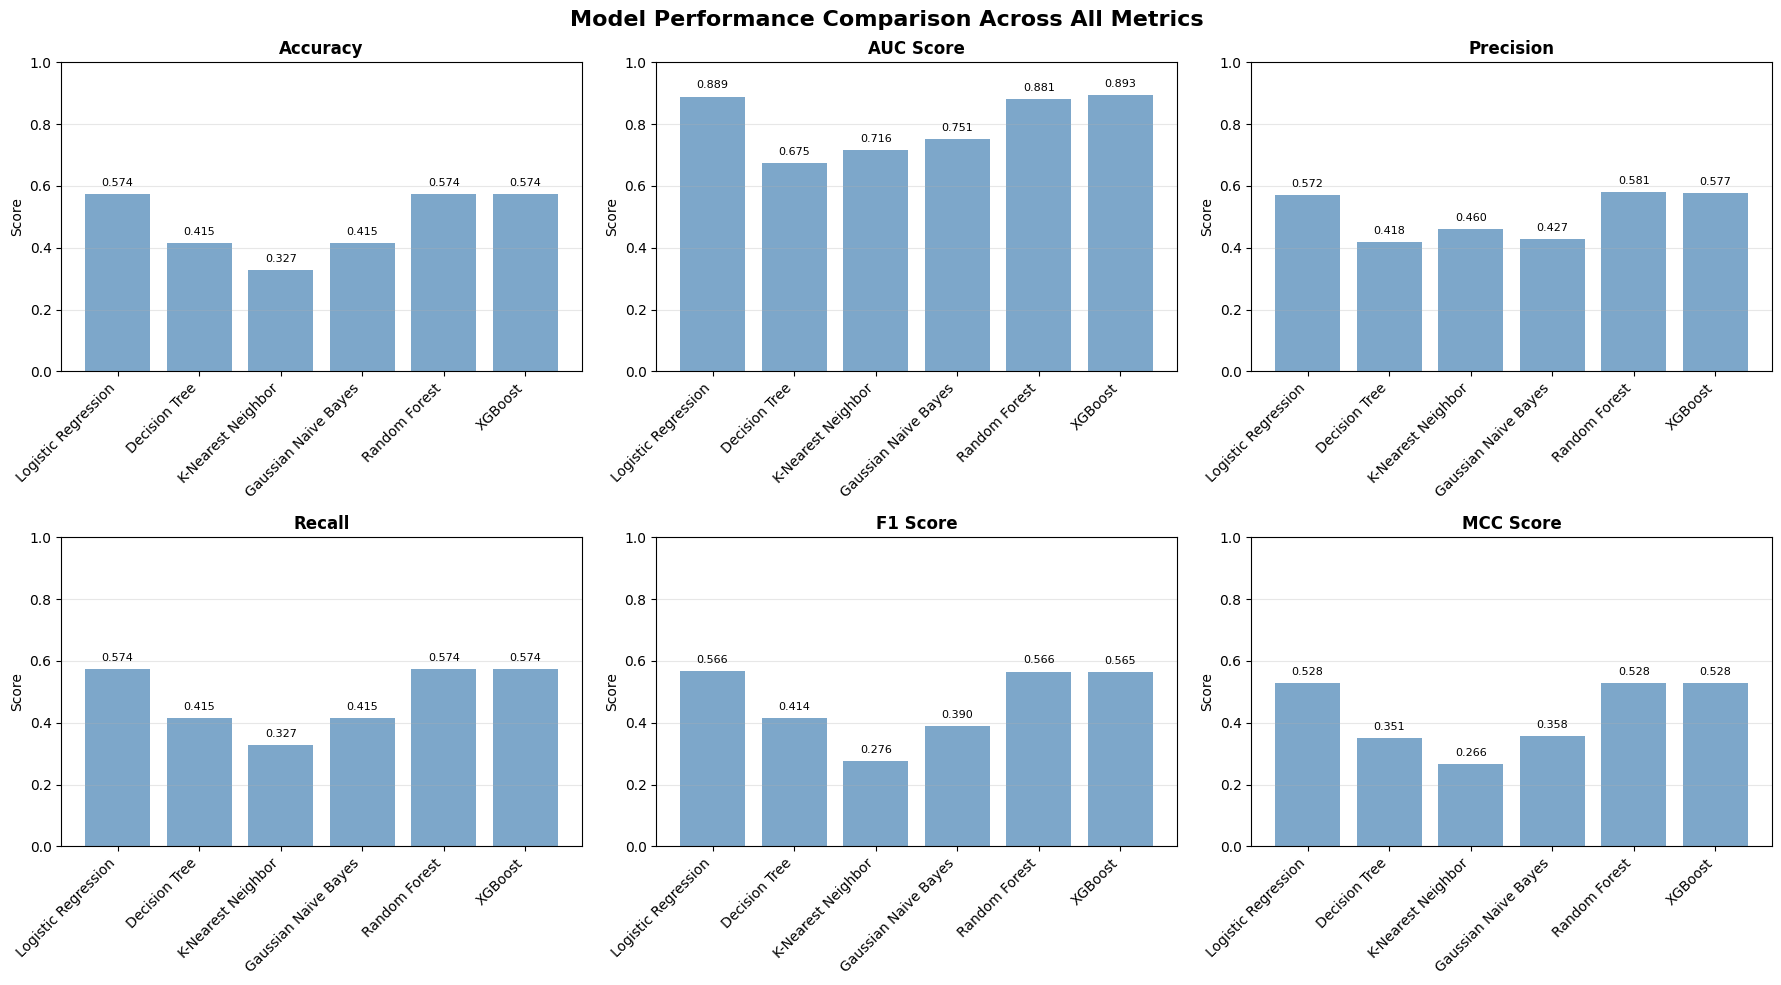

Comparison chart saved as 'model_comparison_chart.png'


In [15]:
# Plot comparison of all metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison Across All Metrics', fontsize=16, fontweight='bold')

metrics_to_plot = ['Accuracy', 'AUC Score', 'Precision', 'Recall', 'F1 Score', 'MCC Score']
model_names = list(all_results.keys())

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 3
    col = idx % 3
    
    values = [all_results[model][metric] for model in model_names]
    
    # Handle 'N/A' values
    values = [v if isinstance(v, (int, float)) else 0 for v in values]
    
    axes[row, col].bar(range(len(model_names)), values, color='steelblue', alpha=0.7)
    axes[row, col].set_title(metric, fontweight='bold')
    axes[row, col].set_ylabel('Score')
    axes[row, col].set_xticks(range(len(model_names)))
    axes[row, col].set_xticklabels(model_names, rotation=45, ha='right')
    axes[row, col].set_ylim([0, 1.0])
    axes[row, col].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[row, col].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('model_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("Comparison chart saved as 'model_comparison_chart.png'")

## 10. Best Model Analysis

In [16]:
# Find best model for each metric
print("\n" + "="*80)
print("BEST MODEL FOR EACH METRIC")
print("="*80)

for metric in metrics_to_plot:
    # Get scores for this metric
    scores = {}
    for model_name in model_names:
        value = all_results[model_name][metric]
        if isinstance(value, (int, float)):
            scores[model_name] = value
    
    if scores:
        best_model = max(scores, key=scores.get)
        best_score = scores[best_model]
        print(f"{metric:<25}: {best_model:<25} (Score: {best_score:.4f})")


BEST MODEL FOR EACH METRIC
Accuracy                 : Logistic Regression       (Score: 0.5735)
AUC Score                : XGBoost                   (Score: 0.8930)
Precision                : Random Forest             (Score: 0.5813)
Recall                   : Logistic Regression       (Score: 0.5735)
F1 Score                 : Logistic Regression       (Score: 0.5660)
MCC Score                : Random Forest             (Score: 0.5280)


## 11. Summary and Conclusions

In [18]:
print("\n" + "="*80)
print("SUMMARY AND CONCLUSIONS")
print("="*80)

print("\n1. Dataset Information:")
print(f"   - Total training samples: {len(X_train)}")
print(f"   - Total validation samples: {len(X_val)}")
print(f"   - Number of classes: {len(classes)}")
print(f"   - Feature dimensions: {X_train.shape[1]}")

print("\n2. Models Implemented:")
for i, model_name in enumerate(model_names, 1):
    print(f"   {i}. {model_name}")

print("\n3. Evaluation Metrics Calculated:")
for i, metric in enumerate(metrics_to_plot, 1):
    print(f"   {i}. {metric}")

print("\n4. Overall Best Performing Model:")
# Calculate average score across all metrics
avg_scores = {}
for model_name in model_names:
    scores = []
    for metric in metrics_to_plot:
        value = all_results[model_name][metric]
        if isinstance(value, (int, float)):
            scores.append(value)
    avg_scores[model_name] = np.mean(scores) if scores else 0

best_overall = max(avg_scores, key=avg_scores.get)
print(f"   {best_overall} with average score: {avg_scores[best_overall]:.4f}")

print("\n" + "="*80)
print("Analysis Complete!")
print("="*80)


SUMMARY AND CONCLUSIONS

1. Dataset Information:
   - Total training samples: 1097
   - Total validation samples: 272
   - Number of classes: 10
   - Feature dimensions: 12288

2. Models Implemented:
   1. Logistic Regression
   2. Decision Tree
   3. K-Nearest Neighbor
   4. Gaussian Naive Bayes
   5. Random Forest
   6. XGBoost

3. Evaluation Metrics Calculated:
   1. Accuracy
   2. AUC Score
   3. Precision
   4. Recall
   5. F1 Score
   6. MCC Score

4. Overall Best Performing Model:
   XGBoost with average score: 0.6182

Analysis Complete!
